<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-Emmanuel-Dominguez-A01793683/blob/main/TecMty_kmeans_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 706 kB/s 
     |████████████████████████████████| 1.0 MB 29.2 MB/s 
     |████████████████████████████████| 1.7 MB 44.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 50.5 MB/s 
     |████████████████████████████████| 6.3 MB 17.7 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=9b43c9032cc47deb275c52f523b2bbf97bfc71219691d73b88c5135b7608de3e
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=f77d9c4fc791be0a7fa932893b162e30af899d6afb0d348b2968e78366066931
  Stored in directory: /root/.

In [19]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

Importa la base de datos

In [3]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [4]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [6]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

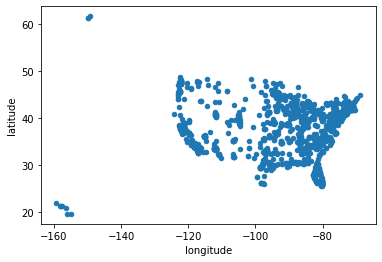

In [7]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [8]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [10]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [11]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [27]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [13]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

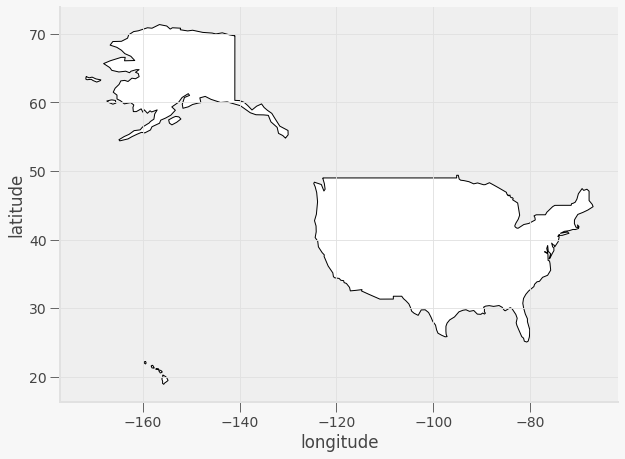

In [14]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

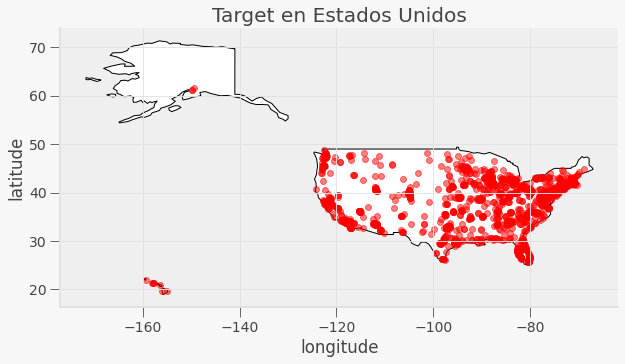

In [15]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

Encuentra el numero ideal de almacenes, justifica tu respuesta:

Encuentra las latitudes y longitudes de los almacenes, ¿qué ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estará?
¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente.

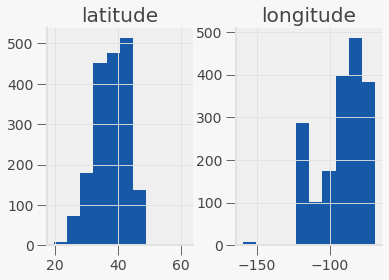

In [17]:
# Graficamos los histogramas para tener una idea de la dispersión de los datos:
latlong.hist()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


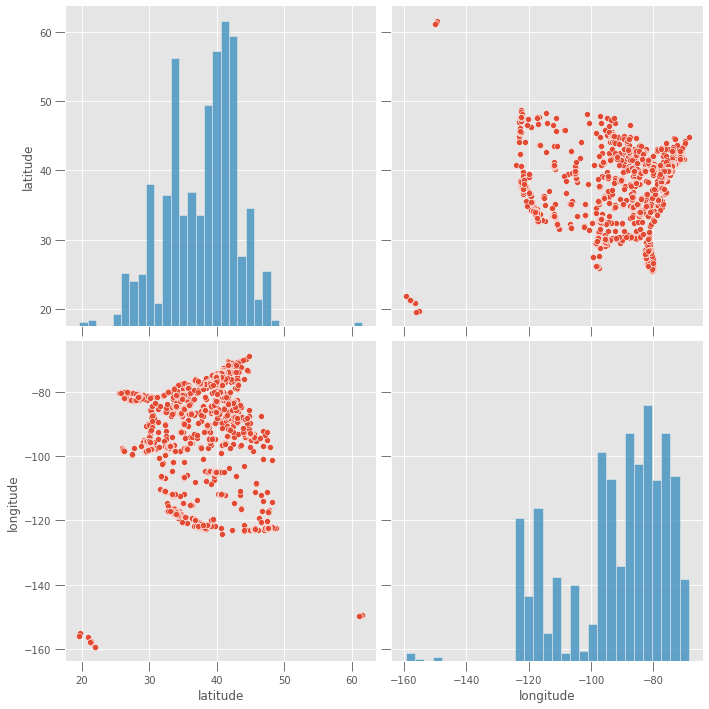

In [24]:
sb.pairplot(df.dropna(),size=5,vars=['latitude','longitude'],kind='scatter')

In [45]:
#Concretamos la estructura de datos que utilizaremos para alimentar el algoritmo

X = np.array(df[['latitude', 'longitude']])
y = np.array(df['Coordinates'])
y.shape
type(X)

numpy.ndarray

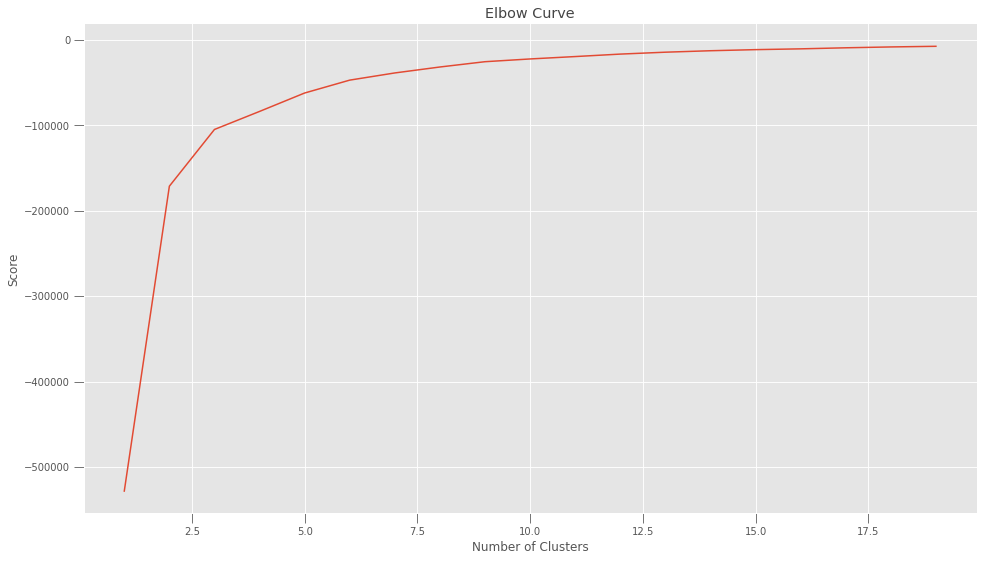

In [47]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [48]:
# En base a la gráfica "elbow", consideramos a K con un valor de 3, que es donde 
# la curva cambia de dirección de manera más drástica

In [105]:
kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[  37.78260864  -78.5343898 ]
 [  37.48734203 -118.62447332]
 [  37.98791364  -93.27994961]]


In [135]:
#Convertimos los datos en coordenadas

lt= ['longitude','latitude']
df_wh = pd.DataFrame(centroids, columns=['longitude','latitude'])
df_wh["Warehouse"] = list(zip(df_wh.latitude,df_wh.longitude))
df_wh["Warehouse"] = df_wh["Warehouse"].apply(Point)
df_wh['City'] = ['Scottsville, VA', 'Mono County, CA', 'Hickory County, MO']
df_wh 


,longitude,latitude,Warehouse,City
0,37.782609,-78.534390,POINT (-78.53438980340219 37.78260864094776),"Scottsville, VA"
1,37.487342,-118.624473,POINT (-118.62447331844157 37.48734203064935),"Mono County, CA"
2,37.987914,-93.279950,POINT (-93.27994961093502 37.98791363565769),"Hickory County, MO"


In [136]:
gdf_wh = gpd.GeoDataFrame(df_wh, geometry="Warehouse")
gdf_wh.head()

,longitude,latitude,Warehouse,City
0,37.782609,-78.534390,POINT (-78.53439 37.78261),"Scottsville, VA"
1,37.487342,-118.624473,POINT (-118.62447 37.48734),"Mono County, CA"
2,37.987914,-93.279950,POINT (-93.27995 37.98791),"Hickory County, MO"


In [137]:
print('gdf is of type:', type(gdf_wh))

gdf is of type: <class 'geopandas.geodataframe.GeoDataFrame'>


In [138]:
print('\nThe geometry column is:', gdf.geometry.name)


The geometry column is: Warehouse


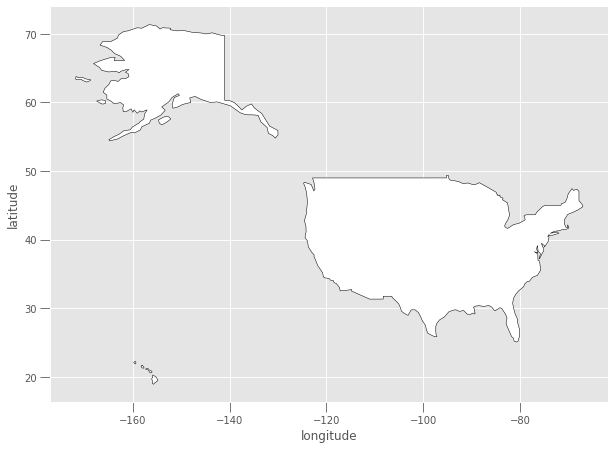

In [139]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

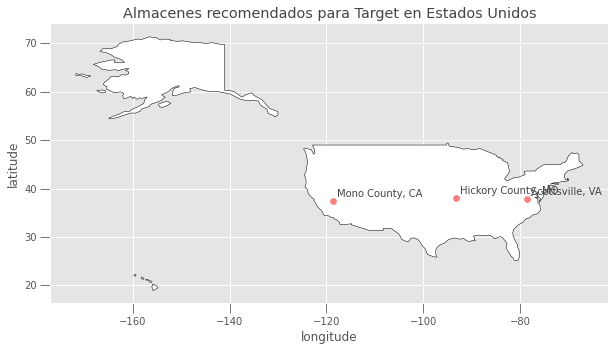

In [151]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf_wh.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Almacenes recomendados para Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

# Label the cities
for x, y, label in zip(gdf_wh['Warehouse'].x, gdf_wh['Warehouse'].y, gdf_wh['City']):
  gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')

plt.show()

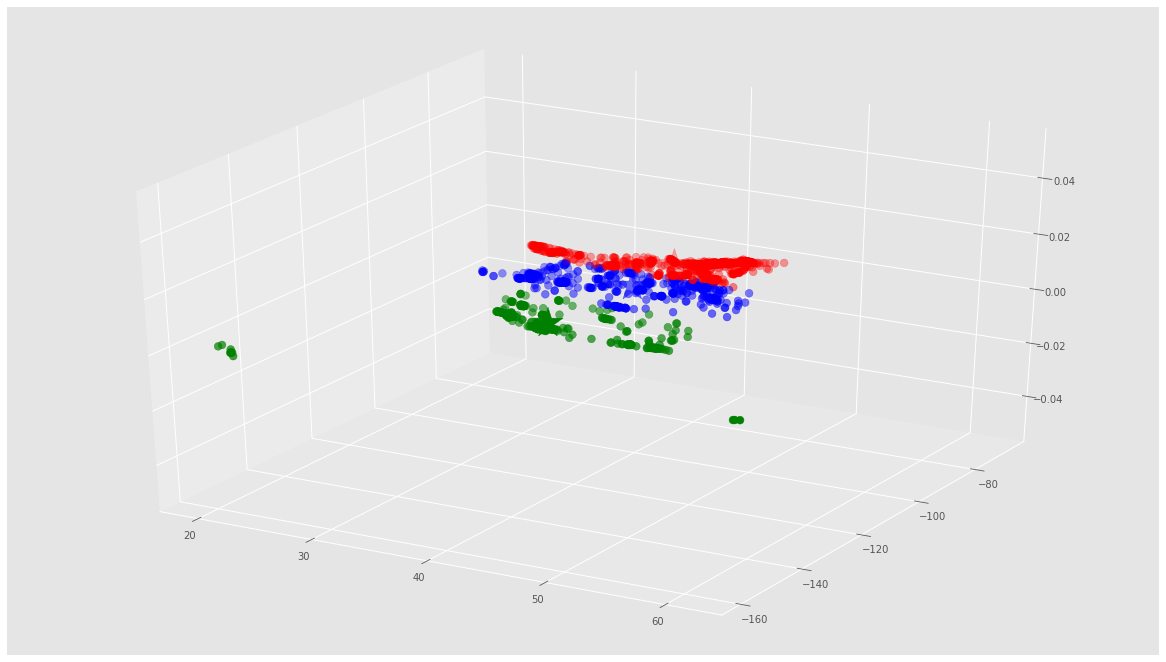

In [153]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)

Aqui podemos ver que el algoritmo de K-Means con K=3 ha agrupado a los diferentes tiendas de Target por su localización, teniendo en cuenta las 2 dimensiones que utilizamos:

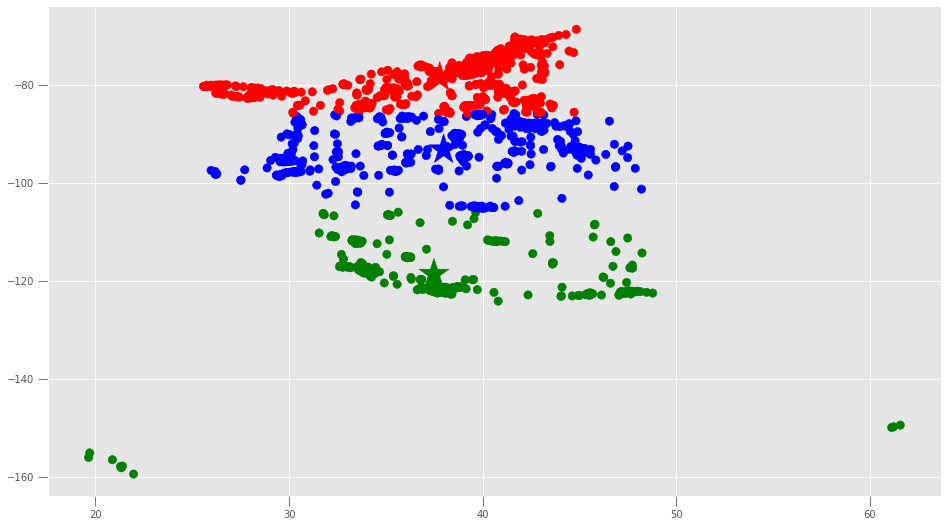

In [154]:
# Haremos 3 gráficas en 2 dimensiones con las proyecciones a partir de nuestra
# gráfica 3D para que nos ayude a visualizar los grupos y su clasificación:

# Getting the values and plotting it
f1 = df['latitude'].values
f2 = df['longitude'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()


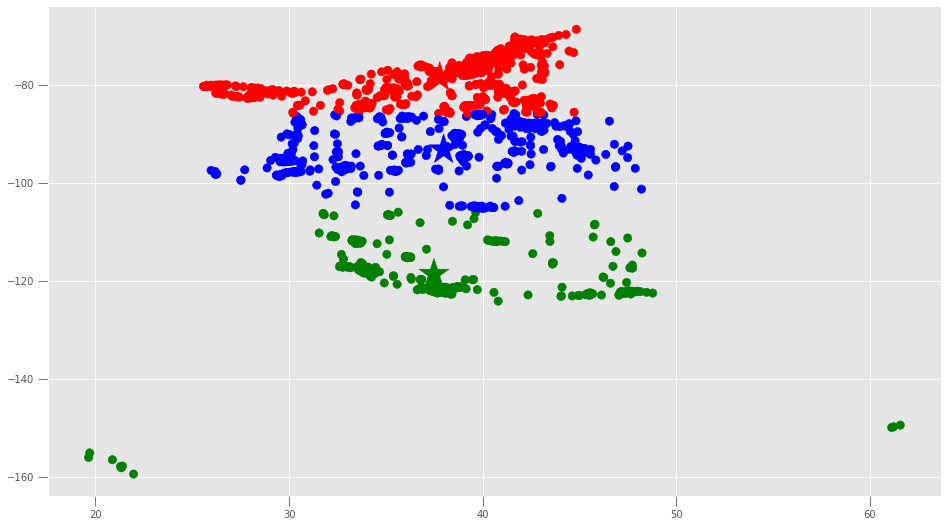

In [155]:
# Getting the values and plotting it
f1 = df['latitude'].values
f2 = df['longitude'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

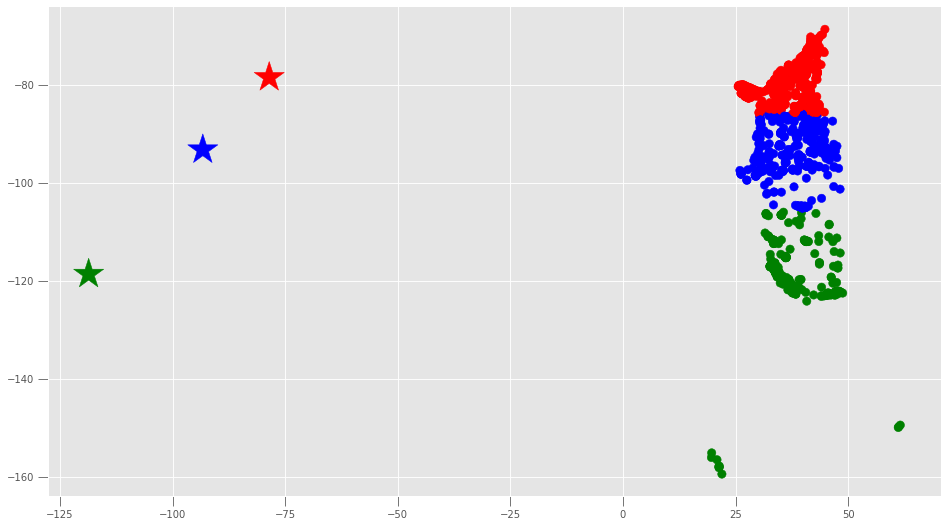

In [156]:
f1 = df['latitude'].values
f2 = df['longitude'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 1], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

In [157]:
#Podemos ver cada uno de los clusters cuántas tiendas tiene:

copy =  pd.DataFrame()
copy['latitude']=df['latitude'].values
copy['longitude']=df['longitude'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,826
1,green,385
2,blue,628


In [160]:
#vemos el representante del grupo, la tienda más cercana a su centroid
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
closest

array([1689,  212,  998])

In [64]:
stores=df['Coordinates'].values
for row in closest:
    print(stores[row])

POINT (-75.6569933 40.26937789999999)
POINT (-119.7283315 36.8403069)
POINT (-98.4953944 34.6298655)
POINT (-83.3159716 30.8431284)
POINT (-88.36536389999999 41.7980199)


Vemos las coordenadas de las tiendas más cercanas a los centroides.

Finalmente podemos agrupar y etiquetar nuevas localidades de tiendas con sus características y clasificarlas. Vemos el ejemplo con la tienda de Alabaster y nos devuelve que pertenece al grupo 3 (cyan).

In [66]:
X_new = np.array([[33.224225, -86.804174]]) #Alabaster

new_labels = kmeans.predict(X_new)
print(new_labels)

[3]


¿qué librerías nos pueden ayudar a graficar este tipo de datos?
¿Consideras importante que se grafique en un mapa?, ¿por qué?
Agrega las conclusiones

Geopandas, NumPy, Matplotlib, ReportLab, Geemap, PyViz/HoloViz (ésta última incluye dashboards interactivos). Folium facilita la visualización en mapas con diferentes capas interactivas a escoger.

No tenía alguna experiencia previa utilizando librerías de datos geoespaciales, pero creo que es una muestra de lo útil que puede llegar a ser su implementación en Python combinándola con modelos de clasificación.